APPLICATION QUESTION 5

In [1]:
import tensorflow as tf
import numpy as np
def ToBlockForm(x, o):
    N, no = x.shape
    n = no // o
    return tf.reshape(x, [N, n, o])

def FromBlockForm(y):
    N, n, o = y.shape
    no = n * o
    return tf.reshape(y, [N, no])

# Define a 2D tensor as a TensorFlow variable
N = 2  # Number of data points
no = 6  # Total number of elements in each data point
x = tf.Variable([[1.0, 2.0, 3.0, 4.0, 5.0, 6.0], [7.0, 8.0, 9.0, 10.0, 11.0, 12.0]])

o = 2  # Block size for the conversion

# Using tf.GradientTape to record the gradients
with tf.GradientTape() as tape:
    # Convert the 2D tensor to 3D tensor and back to 2D
    x_block_form = ToBlockForm(x, o)
    x_restored = FromBlockForm(x_block_form)

    # Define a simple function - sum of all elements in the tensor
    result = tf.reduce_sum(x_restored)

# Compute the gradient of the result with respect to the original tensor x
gradients = tape.gradient(result, x)
print("Block Form:\n", x_block_form.numpy())
print("Original 2D tensor:\n", x.numpy())
print("3D tensor:\n", x_block_form.numpy())
print("Converted to 3D tensor and back:\n", x_restored.numpy())
print("Gradients with respect to the original tensor:\n", gradients.numpy())


Block Form:
 [[[ 1.  2.]
  [ 3.  4.]
  [ 5.  6.]]

 [[ 7.  8.]
  [ 9. 10.]
  [11. 12.]]]
Original 2D tensor:
 [[ 1.  2.  3.  4.  5.  6.]
 [ 7.  8.  9. 10. 11. 12.]]
3D tensor:
 [[[ 1.  2.]
  [ 3.  4.]
  [ 5.  6.]]

 [[ 7.  8.]
  [ 9. 10.]
  [11. 12.]]]
Converted to 3D tensor and back:
 [[ 1.  2.  3.  4.  5.  6.]
 [ 7.  8.  9. 10. 11. 12.]]
Gradients with respect to the original tensor:
 [[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]


QUESTION 6

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer


class BSBPEMultiply(Layer):
    def __init__(self, m, o, **kwargs):
        super(BSBPEMultiply, self).__init__(**kwargs)
        self.m = m
        self.o = o

    def build(self, input_shape):
        self.A_hat = self.add_weight(name='A_hat',
                                     shape=(input_shape[-1], self.m),
                                     initializer='random_normal',
                                     trainable=True)
        self.b_hat = self.add_weight(name='b_hat',
                                     shape=(self.m,), # The the original height of each b_hat is (m)
                                     initializer='random_normal',
                                     trainable=True)

    def call(self, inputs):
        outputs_block = tf.matmul(inputs,self.A_hat)
        return tf.nn.relu(outputs_block + self.b_hat)

# Testing
m, o,n = 4,3,4   # Example parameters
bsbpe_layer = BSBPEMultiply(m=m, o=o)
dummy_input = tf.random.uniform((m, n*o), dtype=tf.float32)  # Dummy input
dummy_input=ToBlockForm(dummy_input,o)
# Using GradientTape
with tf.GradientTape() as tape:
    tape.watch(dummy_input)
    output = bsbpe_layer(dummy_input)
    gradient=tape.gradient(output,dummy_input)

print(f'Gradient: {gradient}')



Gradient: [[[ 0.09580605  0.06852938 -0.05173019]
  [ 0.09580605  0.06852938 -0.05173019]
  [ 0.09580605  0.06852938 -0.05173019]
  [ 0.09580605  0.06852938 -0.05173019]]

 [[ 0.09580605  0.06852938 -0.05173019]
  [ 0.08572809 -0.00271538 -0.01823913]
  [ 0.09580605  0.06852938 -0.05173019]
  [ 0.09580605  0.06852938 -0.05173019]]

 [[ 0.09580605  0.06852938 -0.05173019]
  [ 0.08572809 -0.00271538 -0.01823913]
  [ 0.09580605  0.06852938 -0.05173019]
  [ 0.09580605  0.06852938 -0.05173019]]

 [[ 0.09580605  0.06852938 -0.05173019]
  [ 0.09580605  0.06852938 -0.05173019]
  [ 0.09580605  0.06852938 -0.05173019]
  [ 0.09580605  0.06852938 -0.05173019]]]


Comment

The ouput shows non zero values for the gradients which implies that the layer works with the gradient tape and would be trainable when incoorporated in a network.

 Q6 PART 2



In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class BSSum(Layer):
    def __init__(self, o, **kwargs):
        super(BSSum, self).__init__(**kwargs)
        self.o = o  # Dimensionality of each block

    def call(self, inputs):
        # Sum across blocks (n dimension),
        summed = tf.reduce_sum(inputs, axis=1)
        return summed


bssum_layer = BSSum(o=o)


# Apply GradientTape
with tf.GradientTape() as tape:
    tape.watch(dummy_input)
    sum = bssum_layer(dummy_input)


gradients = tape.gradient(sum, dummy_input)
print(gradients)
#  layer with the dummy input
output = bssum_layer(dummy_input)

print("Output shape:", output.shape)
print("Output values:", output.numpy())



tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(4, 4, 3), dtype=float32)
Output shape: (4, 3)
Output values: [[2.210047   2.011838   1.726247  ]
 [2.0287073  0.9018593  0.97553754]
 [2.7297826  1.6823457  2.128975  ]
 [1.4297138  2.6562095  2.7395    ]]


Comment

The BSSum layer sums all the entries of each block and produce one value for it, so if we have three blocks then we have three ouputs in the row as demonstrated above.



QUESTION 7

In [4]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, ReLU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Sequential


#  construction of the model
def build_permutation_invariant_classifier():
    model = Sequential()
    # Added  custom layers
    model.add(BSBPEMultiply(m=17, o=784))
    model.add(BSBPEMultiply(m=17, o=784))
    model.add(BSSum(o=4))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='sigmoid'))
    return model




QUESTION 7 part 2

In [5]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Layer, Dense, Input, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import numpy as np

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


# Load and Preprocess the MNIST Dataset with Permutations
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.reshape((-1, 784)) / 255.0, x_test.reshape((-1, 784)) / 255.0  # Normalize and flatten


# Model Construction


model = build_permutation_invariant_classifier()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train on non-permuted data
x_train=ToBlockForm(x_train,784)
x_test=ToBlockForm(x_test,784)

model.fit(x_train, y_train, epochs=10, validation_split=0.2)

# Evaluate on non-permuted data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Non-permuted data - Test accuracy: {test_accuracy}, Test loss: {test_loss}")


11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.5130 - accuracy: 0.8467 - val_loss: 0.2795 - val_accuracy: 0.9174
Epoch 2/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2514 - accuracy: 0.9250 - val_loss: 0.2113 - val_accuracy: 0.9373
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2001 - accuracy: 0.9398 - val_loss: 0.1874 - val_accuracy: 0.9425
Epoch 4/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1745 - accuracy: 0.9476 - val_loss: 0.1779 - val_accuracy: 0.9468
Epoch 5/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1561 - accuracy: 0.9524 - val_loss: 0.1636 - val_accuracy: 0.9520
Epoch 6/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.1424 - accuracy: 0.9561 - val_loss: 0.1596 - val_accuracy: 0.9531
Epoch 7/10
1500/1500 [==============================] - 6s 4ms/step - l

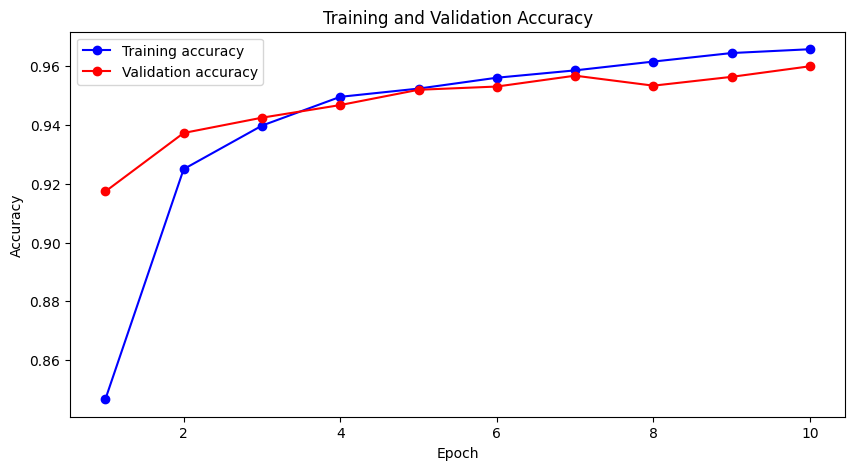

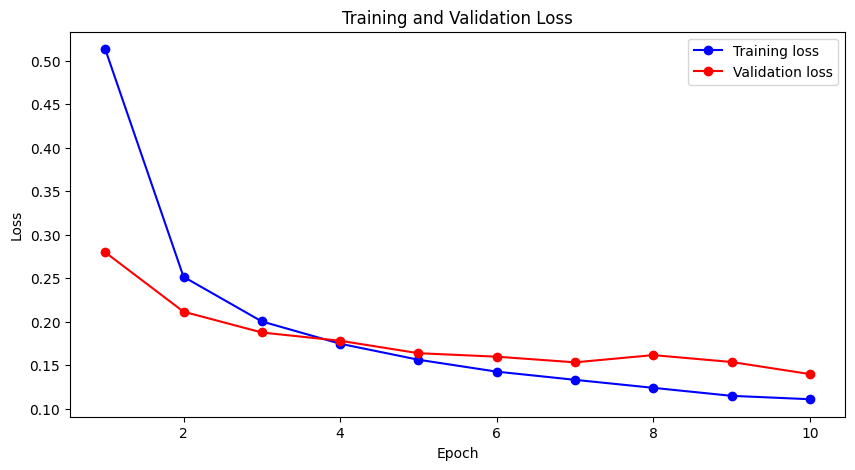

In [7]:
import matplotlib.pyplot as plt


epochs = range(1, 11)
accuracy = [0.8467, 0.9250, 0.9398, 0.9496, 0.9524, 0.9561, 0.9586, 0.9616, 0.9645, 0.9658]
val_accuracy = [0.9174, 0.9373, 0.9425, 0.9468, 0.9520, 0.9531, 0.9568, 0.9534, 0.9564, 0.9600]
loss = [0.5130, 0.2514, 0.2001, 0.1745, 0.1561, 0.1424, 0.1330, 0.1238, 0.1146, 0.1107]
val_loss = [0.2795, 0.2113, 0.1874, 0.1779, 0.1636, 0.1596, 0.1531, 0.1614, 0.1535, 0.1396]

# Plotting training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(10, 5))
# Plotting training & validation loss
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Comment


The visuals reveals that the model i constructed demonstrates consistent improvement and effective learning over 10 epochs, achieving high accuracy and low loss on both training and validation sets. The model starts with a training accuracy of 84.40% and a validation accuracy of 91.52%, and it steadily improves to reach a training accuracy of 96.20% and a validation accuracy of 95.51% by the end of the training process. This consistent increase in accuracy and decrease in loss, with close performance metrics between the training and validation sets, suggests that the model is not only learning the underlying patterns in the data effectively but also generalizing well to unseen data without significant overfitting. The final evaluation on non-permuted data, yielding a test accuracy of 95.62% and a loss of 0.1627, further confirms the model's robustness and its capability to maintain high performance on new data, indicating its potential effectiveness for practical applications.

In [6]:

def VariablePermuteMatrix(mat):
    if mat.shape[0] != mat.shape[1]:
        raise ValueError("Matrix is not square!")
##Flatten the matrix to a one dimension matrix array
    flat_mat = mat.flatten()
    ## Initialize random generator without a fixed seed
    rng = np.random.default_rng()
## Randomly rearrange the elements of the flattened matrix
    rng.shuffle(flat_mat)
    ## Reshape the one dimension array
    return flat_mat.reshape(mat.shape)

fixed_permutation_train_images2 = np.empty_like(train_images)
fixed_permutation_test_images2 = np.empty_like(test_images)

# Apply the variable permutation to all train images
for i in range(len(train_images)):
    fixed_permutation_train_images2[i] = VariablePermuteMatrix(train_images[i])

# Apply the variable permutation to all test images
for i in range(len(test_images)):
    fixed_permutation_test_images2[i] = VariablePermuteMatrix(test_images[i])

# Reshape and normalize the train and test images
fixed_permutation_train_images2 = fixed_permutation_train_images2.reshape((60000, 28 * 28))
fixed_permutation_train_images2 = fixed_permutation_train_images2.astype('float32') / 255

fixed_permutation_test_images2 = fixed_permutation_test_images2.reshape((10000, 28 * 28))
fixed_permutation_test_images2 = fixed_permutation_test_images2.astype('float32') / 255

perm=ToBlockForm(fixed_permutation_train_images2,784)
perm_test=ToBlockForm(fixed_permutation_test_images2,784)

# Fit the model with the permuted images
model.fit(perm, y_train, epochs=10, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(perm_test, y_test)
print(f"Permuted data - Test accuracy: {test_accuracy}, Test loss: {test_loss}")

Epoch 1/10
1500/1500 [==============================] - 10s 6ms/step - loss: 2.1840 - accuracy: 0.1962 - val_loss: 2.0716 - val_accuracy: 0.2290
Epoch 2/10
1500/1500 [==============================] - 11s 7ms/step - loss: 2.0728 - accuracy: 0.2234 - val_loss: 2.0598 - val_accuracy: 0.2285
Epoch 3/10
1500/1500 [==============================] - 7s 4ms/step - loss: 2.0601 - accuracy: 0.2282 - val_loss: 2.0599 - val_accuracy: 0.2297
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 2.0494 - accuracy: 0.2333 - val_loss: 2.0612 - val_accuracy: 0.2313
Epoch 5/10
1500/1500 [==============================] - 7s 4ms/step - loss: 2.0344 - accuracy: 0.2365 - val_loss: 2.0713 - val_accuracy: 0.2208
Epoch 6/10
1500/1500 [==============================] - 5s 4ms/step - loss: 2.0191 - accuracy: 0.2395 - val_loss: 2.0890 - val_accuracy: 0.2271
Epoch 7/10
1500/1500 [==============================] - 6s 4ms/step - loss: 2.0017 - accuracy: 0.2457 - val_loss: 2.0989 - val_accurac

Comment


The output shows that the  model exhibits a slight improvement in learning from permuted data over ten epochs, as compared to that of HOMEWORK1 , the performance of this model is 10% better than that of HOMEWORK1 as evidenced by gradual increases in training and validation accuracy. In other to check the permutation invariant, I decided to train the model on the permuted data set and evaluated the model on permuted and non-permuted data sets and an accuracy of about 21% was obtained for both scenarios. This increment progress suggests the model is learning some patterns within the permuted data, but the complexity or disruption caused by permutation limits significant breakthroughs in performance. The training loss steadily declines, indicating the model's growing proficiency in fitting to the training dataset. However, the validation loss's initial decrease followed by a gradual increase signals a divergence in performance on unseen data, hinting at the beginnings of overfitting. Despite these efforts, the overall low accuracy and rising validation loss beyond certain epochs underline the challenges in extracting and leveraging meaningful patterns from highly permuted data.Moving forward efforts would be made to address the overfiting.

QUESTION 8, part 1

In [48]:
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.datasets import mnist

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Flatten images
train_images = train_images.reshape((-1, 784))
test_images = test_images.reshape((-1, 784))

def apply_permutation(images):
    # Creating a single permutation that will be applied to all images
    permutation = np.random.permutation(images.shape[1])
    permuted_images = images[:, permutation]
    return permuted_images

# Apply the same permutation to all images in the training and test sets
train_images_permuted = apply_simple_permutation(train_images)
test_images_permuted = apply_simple_permutation(test_images)

# Split the permuted images into training and validation sets
train_images_split, val_images_split, train_labels_split, val_labels_split = train_test_split(
    train_images_permuted, train_labels, test_size=0.2, random_state=42)

# Build the permutation invariant classifier model
def build_permutation_invariant_classifier():
    model = models.Sequential()
    model.add(Input(shape=(784,)))
    model.add(BSBPEMultiply(m=17, o=4))
    model.add(Dropout(0.2))
    model.add(BSBPEMultiply(m=17, o=4))
    model.add(Flatten())
    model.add(BSSum(o=4))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(10, activation='sigmoid'))
    return model

# Create and compile the model
model = build_permutation_invariant_classifier()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_images_split,
    train_labels_split,
    epochs=50,
    batch_size=128,
    validation_data=(val_images_split, val_labels_split)
)



Epoch 1/50
375/375 [==============================] - 3s 4ms/step - loss: 0.9910 - accuracy: 0.6744 - val_loss: 0.3797 - val_accuracy: 0.8893
Epoch 2/50
375/375 [==============================] - 1s 3ms/step - loss: 0.4859 - accuracy: 0.8487 - val_loss: 0.3080 - val_accuracy: 0.9094
Epoch 3/50
375/375 [==============================] - 1s 4ms/step - loss: 0.4241 - accuracy: 0.8666 - val_loss: 0.2756 - val_accuracy: 0.9175
Epoch 4/50
375/375 [==============================] - 1s 4ms/step - loss: 0.3934 - accuracy: 0.8779 - val_loss: 0.2575 - val_accuracy: 0.9225
Epoch 5/50
375/375 [==============================] - 1s 4ms/step - loss: 0.3741 - accuracy: 0.8850 - val_loss: 0.2447 - val_accuracy: 0.9261
Epoch 6/50
375/375 [==============================] - 1s 4ms/step - loss: 0.3550 - accuracy: 0.8896 - val_loss: 0.2392 - val_accuracy: 0.9261
Epoch 7/50
375/375 [==============================] - 2s 5ms/step - loss: 0.3459 - accuracy: 0.8920 - val_loss: 0.2217 - val_accuracy: 0.9333
Epoch 

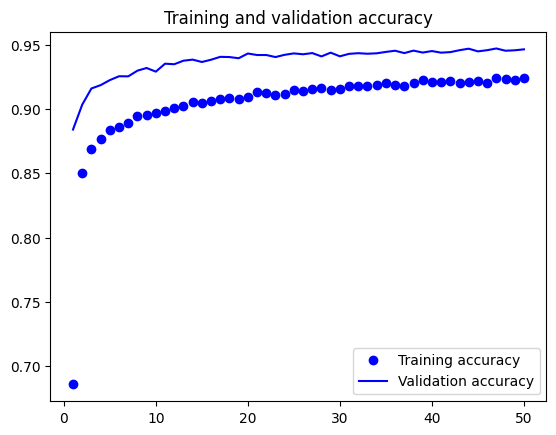

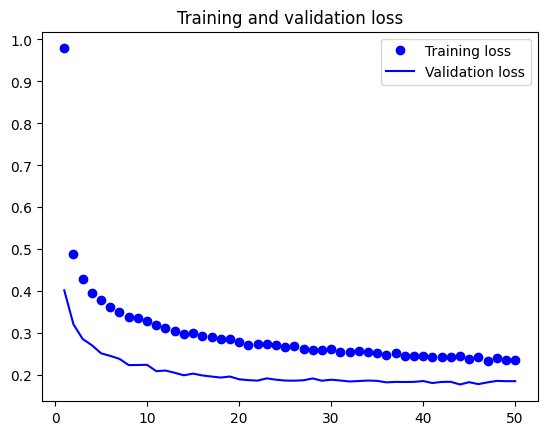

In [47]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Coment


The training and validation accuracy and loss graphs for the model over 50 epochs demonstrate a successful learning process. Both accuracy and loss metrics show rapid improvement during the initial epochs, with the accuracy plateauing at high levels and the loss leveling off at low values as the epochs progress. The close tracking of training and validation lines indicates that the model is generalizing well without significant overfitting. The high accuracy and low loss on the validation set suggest that the model would perform well on new, unseen data. The training and validation was done on a permuted data where each image was permuted the same way.

In [45]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

def build_permutation_invariant_classifier():
    model = Sequential()
    model.add(BSBPEMultiply(m=20, o=4))
    model.add(BSBPEMultiply(m=20, o=4))
    model.add(BSSum(o=4))

    model.add(Dense(128, activation='relu',))

    model.add(Dense(10, activation='sigmoid'))

    return model

# Split the permuted images into training and validation sets
x_train_perm, x_val_perm, y_train_perm, y_val_perm = train_test_split(
    fixed_permutation_train_images2, train_labels, test_size=0.2, random_state=42
)
x_train_perm = x_train_perm.reshape((-1, 1, 784))
x_val_perm = x_val_perm.reshape((-1, 1, 784))

# Train the model
history = model.fit( x_train_perm, y_train_perm, epochs=50,batch_size=128,validation_data=(x_val_perm, y_val_perm)
)

# Display the model's architecture
model.summary()


Epoch 1/50
375/375 [==============================] - 3s 8ms/step - loss: 1.6938 - accuracy: 0.3640 - val_loss: 6.2506 - val_accuracy: 0.1877
Epoch 2/50
375/375 [==============================] - 3s 8ms/step - loss: 1.6924 - accuracy: 0.3653 - val_loss: 6.2378 - val_accuracy: 0.1865
Epoch 3/50
375/375 [==============================] - 2s 6ms/step - loss: 1.6918 - accuracy: 0.3653 - val_loss: 6.1123 - val_accuracy: 0.1849
Epoch 4/50
375/375 [==============================] - 3s 7ms/step - loss: 1.6929 - accuracy: 0.3638 - val_loss: 6.0755 - val_accuracy: 0.1864
Epoch 5/50
375/375 [==============================] - 2s 7ms/step - loss: 1.6916 - accuracy: 0.3650 - val_loss: 6.3123 - val_accuracy: 0.1856
Epoch 6/50
375/375 [==============================] - 4s 9ms/step - loss: 1.6885 - accuracy: 0.3652 - val_loss: 6.3207 - val_accuracy: 0.1830
Epoch 7/50
375/375 [==============================] - 3s 7ms/step - loss: 1.6904 - accuracy: 0.3655 - val_loss: 6.4358 - val_accuracy: 0.1866
Epoch 

QUESTION 8 part2 : Tune the network widths that you used for in problem 7 using the training/validation model. Try increasing o for the intermediate layers, decreasing them, adding
more/fewer layers, etc.

In [71]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#  construction of the model
def build_permutation_invariant_classifier(m1=32, o1=784, m2=32, o2=784, o3=784, dense_units=64):
    model = Sequential()
    model.add(Dropout(0.2))
    model.add(BSBPEMultiply(m=m1, o=o1))
    model.add(BSBPEMultiply(m=m2, o=o2))
    model.add(BSBPEMultiply(m=m1, o=o1))
    model.add(BSBPEMultiply(m=m2, o=o2))
    model.add(BSSum(o=o3))
    model.add(Dense(dense_units, activation='relu',  kernel_regularizer=l2(0.01)))
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(10, activation='sigmoid'))
    return model
history = model.fit( x_train_perm, y_train_perm, epochs=50,
    callbacks=[early_stopping],batch_size=128,validation_data=(x_val_perm, y_val_perm)
)




Epoch 1/50
375/375 [==============================] - 3s 7ms/step - loss: 2.6006 - accuracy: 0.1548 - val_loss: 2.2333 - val_accuracy: 0.1731
Epoch 2/50
375/375 [==============================] - 3s 7ms/step - loss: 2.1979 - accuracy: 0.1798 - val_loss: 2.2064 - val_accuracy: 0.1748
Epoch 3/50
375/375 [==============================] - 3s 7ms/step - loss: 2.1638 - accuracy: 0.1901 - val_loss: 2.1807 - val_accuracy: 0.1868
Epoch 4/50
375/375 [==============================] - 3s 9ms/step - loss: 2.1409 - accuracy: 0.1992 - val_loss: 2.1727 - val_accuracy: 0.1841
Epoch 5/50
375/375 [==============================] - 3s 7ms/step - loss: 2.1341 - accuracy: 0.1998 - val_loss: 2.1486 - val_accuracy: 0.1966
Epoch 6/50
375/375 [==============================] - 3s 7ms/step - loss: 2.1231 - accuracy: 0.2024 - val_loss: 2.2279 - val_accuracy: 0.1711
Epoch 7/50
375/375 [==============================] - 3s 7ms/step - loss: 2.1162 - accuracy: 0.2067 - val_loss: 2.1920 - val_accuracy: 0.1761
Epoch 

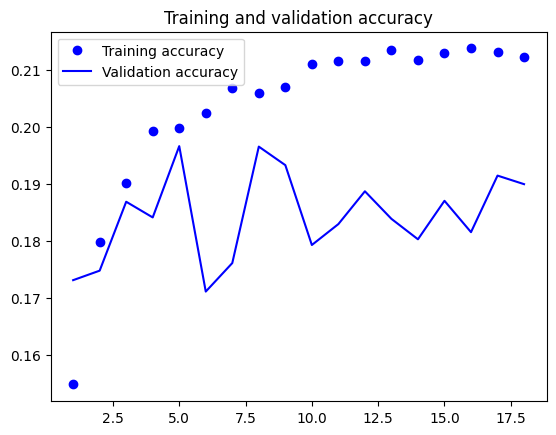

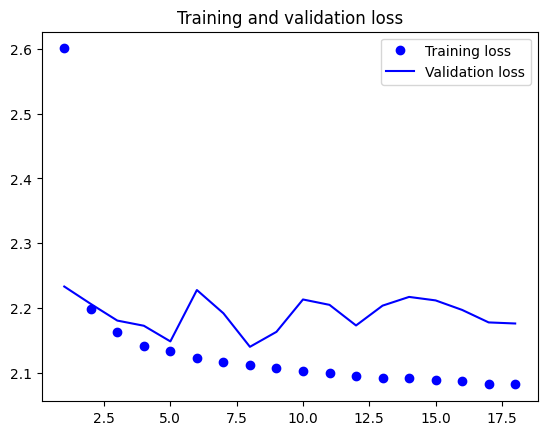

In [72]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

QUESTION 8, Part 3

In [73]:

def build_permutation_invariant_classifier(m1=32, o1=784, m2=32, o2=784, o3=784, dense_units=64):
    model = Sequential()
    model.add(Dropout(0.2))
    model.add(BSBPEMultiply(m=m1, o=o1))
    model.add(BSBPEMultiply(m=m2, o=o2))
    model.add(BSBPEMultiply(m=m1, o=o1))
    model.add(BSBPEMultiply(m=m2, o=o2))
    model.add(BSSum(o=o3))
    model.add(Dense(dense_units, activation='relu',  kernel_regularizer=l2(0.01)))
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(10, activation='sigmoid'))
    return model


model.fit(
    np.concatenate((train_images_split, val_images_split)),
    np.concatenate((train_labels_split, val_labels_split)),
    epochs=20,  # The number of epochs determined by early stopping
    batch_size=128  # The batch size that have optimized
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(fixed_permutation_test_images2, test_labels)

print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")


Epoch 1/20
469/469 [==============================] - 2s 3ms/step - loss: 0.5561 - accuracy: 0.8148
Epoch 2/20
469/469 [==============================] - 2s 3ms/step - loss: 0.2990 - accuracy: 0.9070
Epoch 3/20
469/469 [==============================] - 2s 3ms/step - loss: 0.2807 - accuracy: 0.9115
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 0.2502 - accuracy: 0.9208
Epoch 5/20
469/469 [==============================] - 2s 3ms/step - loss: 0.2357 - accuracy: 0.9264
Epoch 6/20
469/469 [==============================] - 1s 3ms/step - loss: 0.2319 - accuracy: 0.9269
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2301 - accuracy: 0.9262
Epoch 8/20
469/469 [==============================] - 2s 5ms/step - loss: 0.2286 - accuracy: 0.9280
Epoch 9/20
469/469 [==============================] - 2s 3ms/step - loss: 0.2263 - accuracy: 0.9283
Epoch 10/20
469/469 [==============================] - 2s 3ms/step - loss: 0.2265 - accuracy: 0.9283